In [101]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import functools
import random

print(tf.__version__)
print(tfds.__version__)
print(hub.__version__)

2.9.2
4.6.0
0.12.0


## Load Dataset and pre-process

In [102]:
# Get the Image Dataset 
Dataset = tfds.load("imagenette")

In [103]:
# Prepare training data

def extract_image(example):
    image = example['image']
    return image


def preprocess_image(image, height, width):
    image = tf.image.resize_with_crop_or_pad(image, target_height=height, target_width=width)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def get_image_batches(batch_size=128, height=256, width=256,training_or_testing=True):
    partial_preprocess_image = functools.partial(preprocess_image, height=height, width=width)
    Images_batch =[]
    if(training_or_testing):
        Images_batch =  Dataset['train']
    else:
        Images_batch =  Dataset['validation']   
    Images_batch = ( Images_batch.map(extract_image)
                .map(partial_preprocess_image)
                .cache()
                .shuffle(buffer_size=1000)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE)
                )
    return Images_batch

In [104]:
print(Dataset)

{'train': <PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'validation': <PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [105]:
# Preparing Training dataset images
BATCH_SIZE = 32
FIXED_IMG_WIDTH = FIXED_IMG_HEIGHT = 256
Training_Dataset = get_image_batches(batch_size=BATCH_SIZE, height=FIXED_IMG_HEIGHT, width=FIXED_IMG_WIDTH) 

In [106]:
# Store image dataset in a numpy array
training_images=[]
for batch in Training_Dataset.take(40):
    for img in batch:   
        training_images.append(img) # take 20 batches 
training_images = np.array(training_images)
print(training_images.shape)

(1280, 256, 256, 3)


## Creating Feature vector using CNN

In [107]:
# Loading pre-trained Deep neural network model to extract features
vectorizer = \
tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",\
                   trainable=False)
            ])
vectorizer.build([None, FIXED_IMG_HEIGHT, FIXED_IMG_WIDTH, 3])

In [ ]:
CNN_extract_features_from_image =[]
image_paths =1
load_image = model =1
resize_image =1

In [ ]:
images = []
for image_path in image_paths:
  image = load_image(image_path)
  image = resize_image(image, size=(224, 224))
  images.append(image)

# Extract features from the images using a pretrained CNN model
features = []
for image in images:
  feature = CNN_extract_features_from_image(image, model)
  features.append(feature)

# Create a KNN model and fit it to the features
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(features)

# Find the nearest neighbors of each image using the KNN model
neighbors = knn.kneighbors(features, return_distance=False)

# For each image, print the indices of the nearest neighbors
for i, neighbor_indices in enumerate(neighbors):
  print(f'Image {i} is most similar to images {neighbor_indices}')

tf.keras.Sequential is a class in the TensorFlow library that allows you to build a sequential model in TensorFlow by stacking layers in a linear order. A sequential model is a linear stack of layers, where the output of one layer is passed as input to the next layer.
Once we have defined your model, we can compile it by specifying the loss function and optimizer to use, and then fit it to your data by calling the fit method. You can then use the model to make predictions on new data by calling the predict method.
tf.keras.Sequential is a convenient way to build simple models in TensorFlow and is often used for tasks such as image classification, text classification, and time series forecasting.
The build method is an important part of the Sequential model API and is used to define the structure of the model. It allows you to easily add layers to the model and modify the model as needed.


In [108]:
# Creating Feature vector
features = vectorizer.predict(training_images, batch_size=BATCH_SIZE)
print(features.shape)

40/40 [==============================] - 311s 8s/step
(1280, 1536)


In [109]:
print(vectorizer)

## Using KNN model to Fit the features into clusters

In [110]:
# Training KNN on feature vector and creating clusters (Fitting)
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(features)

NearestNeighbors(metric='cosine')

## Pick one random image to find more similar images

In [111]:
# Preparing Test dataset images
BATCH_SIZE = 32
FIXED_IMG_WIDTH = FIXED_IMG_HEIGHT = 256
Test_Dataset = get_image_batches(batch_size=BATCH_SIZE, height=FIXED_IMG_HEIGHT, width=FIXED_IMG_WIDTH,training_or_testing=False) 

In [112]:
# Store Test image dataset in a numpy array
Test_images=[]
for batch in Training_Dataset.take(5):
    for img in batch:   
        Test_images.append(img) # take 20 batches 
Test_images = np.array(Test_images)
print(Test_images.shape)

(160, 256, 256, 3)


1/1 [==============================] - 0s 277ms/step


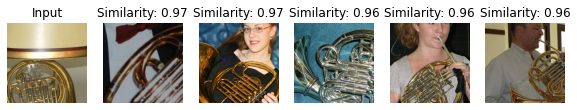

In [130]:
pick_rand_img = random.randint(0,Test_images.shape[0])

image = Test_images[ pick_rand_img ] # take an existing image or create a numpy array from PIL image
image = np.expand_dims(image, 0) # add a batch dimension
feature = vectorizer.predict(image)
nbor_images =[]

distances, nearest_neighbours = knn.kneighbors(feature)
# output is a tuple of list of distances and list nearest_neighbours of each image
# so we take the first entry from those lists since we have only one image
distances, nearest_neighbours = distances[0], nearest_neighbours[0]

for i in nearest_neighbours:
    nbor_images.append(training_images[i])

fig, axes = plt.subplots(1, len(nearest_neighbours)+1, figsize=(10, 5))

for i in range(len(nbor_images)+1):
    ax = axes[i]
    ax.set_axis_off()
    if i == 0:
        ax.imshow(image.squeeze(0))
        ax.set_title("Input")
    else:
        ax.imshow(nbor_images[i-1])
        # we get cosine distance, to convert to similarity we do 1 - cosine_distance
        ax.set_title(f"Similarity: {1 - distances[i-1]:.2f}")
        

In [99]:
image.shape

(1, 256, 256, 3)

## Find similar images for multiple test images

1/1 [==============================] - 1s 1s/step


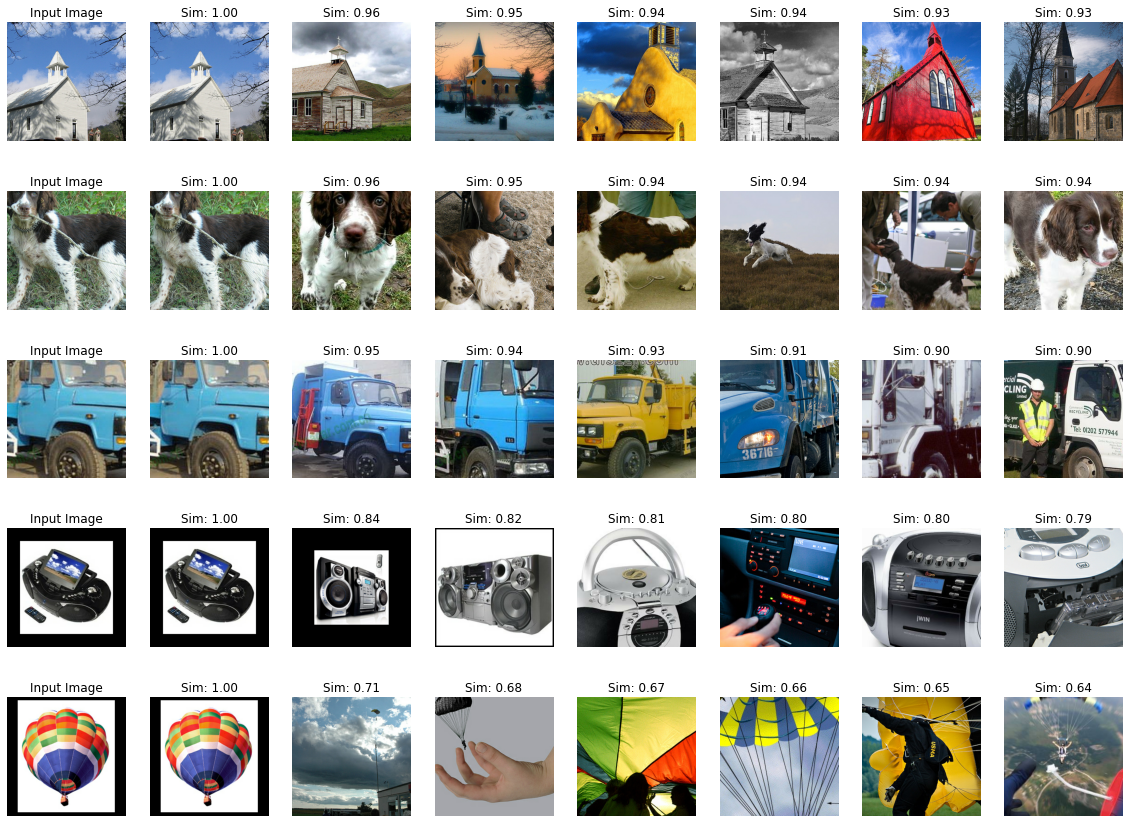

In [117]:
def show_similar_images(start_image_idx, n_inputs=5, n_neighbors=10):
    input_images = Test_images[start_image_idx:start_image_idx+n_inputs]
    features = vectorizer.predict(input_images)
    knn_output = knn.kneighbors(features, n_neighbors=n_neighbors)
    
    images_with_distances_and_nearest_neighbours = zip(input_images, *knn_output)
    
    fig, axes = plt.subplots(len(input_images), n_neighbors+1, figsize=(20, len(input_images)*3))
    
    for i, (image, distances, nearest_neighbours) in enumerate(images_with_distances_and_nearest_neighbours):
        for j in range(n_neighbors+1):
            ax = axes[i, j]
            img = image if j==0 else training_images[nearest_neighbours[j-1]]
            if j == 0:
                ax.set_title("Input Image")
            else:
                ax.set_title(f"Sim: {1-distances[j-1]:.2f}")
            ax.set_axis_off()
            ax.imshow(img)

    fig.savefig("02-image-search-grid.png")

import ipywidgets as w
w.interact(show_similar_images, 
    start_image_idx=w.IntSlider(max=len(Test_images)-1, continuous_update=False),
    n_inputs=w.IntSlider(min=2, value=5, max=10, continuous_update=False),
    n_neighbors=w.IntSlider(min=2, value=5, max=10, continuous_update=False),
)